In [2]:
import datetime as dt
import sys
from typing import Dict, List

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np


In [3]:
from forecast_research.forecast_wrapper import forecast_model


2025-09-16 20:05:48.497310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:

# Index metadata
symbols = {
    "TSX_Composite": {
        "etf_ticker": "XIC.TO",
        "ticker": "^GSPTSE",
        "name": "TSX_Composite",
        "description": "S&P/TSX Composite Index: Overall Canadian market",
        "type": "equity"
    },
    "Canada_Financials_Index": {
        "etf_ticker": "XFN.TO",
        "ticker": "^SPTTFS",
        "name": "Canada_Financials_Index",
        "description": "iShares S&P/TSX Capped Financials Index ETF: Major Canadian banks and financial institutions",
        "type": "equity"
    },
    "Canada_Energy_Index": {
        "etf_ticker": "XEG.TO",
        "ticker": "^SPTTEN",
        "name": "Canada_Energy_Index",
        "description": "iShares S&P/TSX Capped Energy Index ETF: Major Canadian energy companies",
        "type": "equity"
    },
    "Canada_Materials_Index": {
        "etf_ticker": "XMA.TO",
        "ticker": "^GSPTTMT",
        "name": "Canada_Materials_Index",
        "description": "iShares S&P/TSX Capped Materials Index ETF: Major Canadian mining and materials companies",
        "type": "equity"
    },
    "Canada_Information_Technology_Index": {
        "etf_ticker": "XIT.TO",
        "ticker": "^SPTTTK",
        "name": "Canada_Information_Technology_Index",
        "description": "iShares S&P/TSX Capped Information Technology Index ETF: Major Canadian technology companies",
        "type": "equity"
    },
    "Canada_Utilities_Index": {
        "etf_ticker": "XUT.TO",
        "ticker": "^GSPTTUT",
        "name": "Canada_Utilities_Index",
        "description": "iShares S&P/TSX Capped Utilities Index ETF: Major Canadian utilities companies",
        "type": "equity"
    },
    "Canada_Consumer_Staples_Index": {
        "etf_ticker": "XST.TO",
        "ticker": "^GSPTTCS",
        "name": "Canada_Consumer_Staples_Index",
        "description": "iShares S&P/TSX Capped Consumer Staples Index ETF: Major Canadian consumer staples companies",
        "type": "equity"
    },
    "Canada_Real_Estate_Index": {
        "etf_ticker": "XRE.TO",
        "ticker": "^GSPRTRE",
        "name": "Canada_Real_Estate_Index",
        "description": "iShares S&P/TSX Capped REIT Index ETF: Major Canadian real estate investment trusts",
        "type": "equity"
    },
    "Canada_Health_Care_Index": {
        "etf_ticker": "XHC.TO",
        "ticker": "^SPTSXHCR",  # No exact match confirmed; closest standard format retained, as Health Care sector has limited index coverage on Yahoo Finance
        "name": "Canada_Health_Care_Index",
        "description": "iShares S&P/TSX Capped Health Care Index ETF: Major Canadian health care companies",
        "type": "equity"
    },
    "Canada_Consumer_Discretionary_Index": {
        "etf_ticker": "XMD.TO",
        "ticker": "^GSPTTCD",
        "name": "Canada_Consumer_Discretionary_Index",
        "description": "iShares S&P/TSX Capped Consumer Discretionary Index ETF: Major Canadian consumer discretionary companies",
        "type": "equity"
    },
    "Canada_Corporate_Bonds": {
        "etf_ticker": "XCB.TO",
        "ticker": "XCB.TO",
        "name": "Canada_Corporate_Bonds",
        "description": "iShares Canadian Corporate Bond Index ETF: Broad exposure to Canadian investment-grade corporate bonds",
        "type": "bond"
    },
    "Canada_Government_Bonds": {
        "etf_ticker": "XGB.TO",
        "ticker": "XGB.TO",
        "name": "Canada_Government_Bonds",
        "description": "iShares Canadian Government Bond Index ETF: Broad exposure to Canadian government bonds",
        "type": "bond"
    },
    "US_oil_gas": {
        "etf_ticker": "IEO",
        "ticker": "^IXE",
        "name": "US_oil_gas",
        "description": "iShares U.S. Oil & Gas Exploration & Production ETF: Major U.S. oil and gas companies",
        "type": "equity"
    },
    "Global_Materials": {
        "etf_ticker": "MXI",
        "ticker": "^MXWD",
        "name": "Global_Materials",
        "description": "iShares Global Materials ETF: Major global materials companies",
        "type": "equity"
    },
    "US_Government_Bonds": {
        "etf_ticker": "GOVT",
        "ticker": "^SP500BDT",
        "name": "US_Government_Bonds",
        "description": "iShares U.S. Treasury Bond ETF: Broad exposure to U.S. Treasury bonds across various maturities",
        "type": "bond"
    },
    "US_Real_Estate": {
        "etf_ticker": "VNQ",
        "ticker": "^SP500-60",
        "name": "US_Real_Estate",
        "description": "Vanguard Real Estate ETF: Exposure to U.S. real estate investment trusts (REITs) and real estate companies",
        "type": "equity"
    },
    "SP_500": {
        "etf_ticker": "SPY",
        "ticker": "^GSPC",
        "name": "SP_500",
        "description": "S&P 500 Index: Overall U.S. market",
        "type": "equity"
    },
    "CAD_to_USD": {
        "etf_ticker": "CADUSD=X",
        "ticker": "CADUSD=X",
        "name": "CAD_to_USD",
        "description": "Canadian Dollar to US Dollar exchange rate",
        "type": "forex"
    }
}

start = dt.date(2019, 1, 1)
end = dt.date(2024, 12, 31)

In [9]:
tickers = [info["etf_ticker"] for info in symbols.values()]
names = {info["etf_ticker"]: info["name"] for info in symbols.values()}
ticker_downloads = yf.download(
    tickers=tickers,
    interval='1wk',
    start=start,
    end=end
)

pc = ticker_downloads.pct_change().replace([np.inf, -np.inf], np.nan)
mask = pc > 0.8
ticker_downloads = ticker_downloads.where(~mask, ticker_downloads.shift(1))

stocks = pd.DataFrame(ticker_downloads["Close"]).rename(columns=names)
stocks_norm = stocks/stocks.iloc[0,:]  # Normalize to 100% at start date
combined = pd.concat({'Original': stocks, 'Normalized': stocks_norm, 'Returns': stocks.pct_change()}, axis=1)
combined['Normalized'].head()

/tmp/ipykernel_136/1690008442.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ticker_downloads = yf.download(
[*********************100%***********************]  18 of 18 completed
/tmp/ipykernel_136/1690008442.py:12: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ticker_downloads = ticker_downloads.where(~mask, ticker_downloads.shift(1))


Ticker,CAD_to_USD,US_Government_Bonds,US_oil_gas,Global_Materials,SP_500,US_Real_Estate,Canada_Corporate_Bonds,Canada_Energy_Index,Canada_Financials_Index,Canada_Government_Bonds,Canada_Health_Care_Index,TSX_Composite,Canada_Information_Technology_Index,Canada_Materials_Index,Canada_Consumer_Discretionary_Index,Canada_Real_Estate_Index,Canada_Consumer_Staples_Index,Canada_Utilities_Index
Date,,,,,,,,,,,,,,,,,,
2019-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2019-01-08,1.007680,0.997984,1.030858,1.009704,1.011872,1.032511,1.003874,1.036877,1.029947,0.998125,1.004666,1.032972,1.035935,1.016921,1.040268,1.039100,1.028169,1.016216
2019-01-15,1.007104,0.995163,1.063509,1.037283,1.047488,1.058361,1.005811,1.057484,1.067234,0.996718,1.033556,1.056399,1.070185,1.016921,1.052796,1.043839,1.028169,1.040786
2019-01-22,1.011217,0.997984,1.025475,1.029792,1.036874,1.082612,1.007748,1.021692,1.064298,0.997187,1.012666,1.061605,1.087591,1.051607,1.064877,1.063389,1.021127,1.047175
2019-01-29,1.020635,0.997582,1.061356,1.055158,1.069109,1.112592,1.014682,1.034707,1.077459,1.003005,1.041555,1.077657,1.122965,1.087140,1.086801,1.070623,1.030458,1.061569


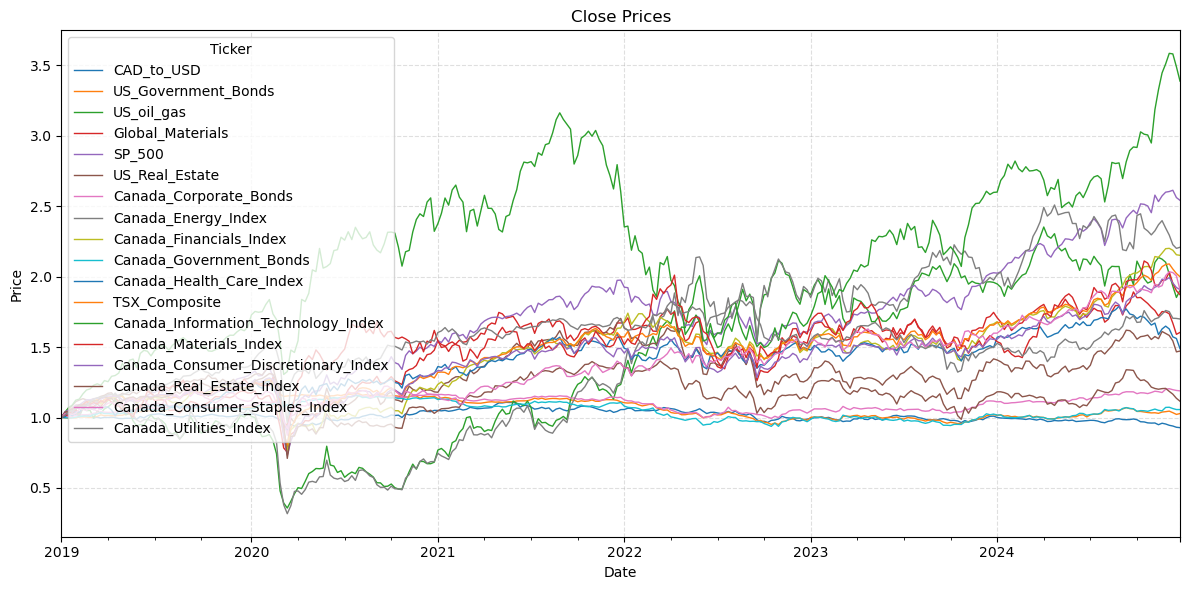

In [10]:

plot_data = combined['Normalized'].dropna()

# Plot
ax = plot_data.plot(figsize=(12, 6), linewidth=1.0)
ax.set_title("Close Prices")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


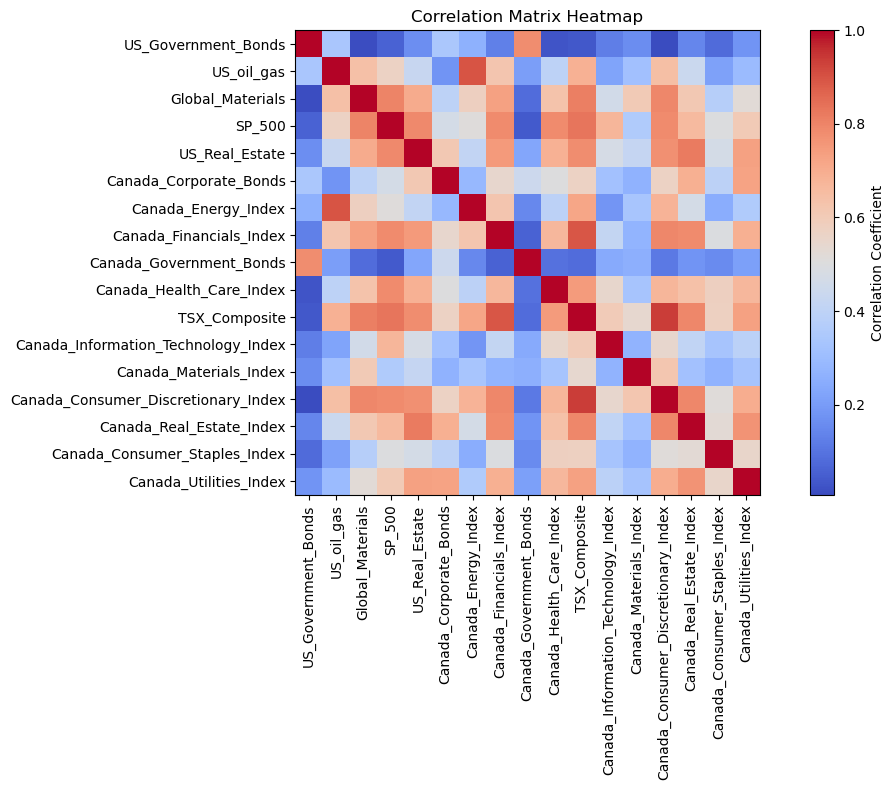

In [7]:
# Compute the correlation matrix
correlation_matrix = combined["Returns"].corr().abs()

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation Coefficient")
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()


In [20]:
train, test = combined["Returns"][1::][:'2023'].reset_index(inplace=False, drop=True), combined["Returns"]['2024':][0:5].reset_index(inplace=False, drop=True)
xreg_cols = [col for col in combined["Returns"].columns if col != "TSX_Composite"]
y_train, y_test = train["TSX_Composite"], test["TSX_Composite"]
xreg_train, xreg_test = train[xreg_cols], test[xreg_cols]
obs_formula = "1 ~" + " ~".join(xreg_cols)


In [22]:
forecast_model(
    model="HMM",
    y_train=train["TSX_Composite"],
    steps=5,
    xreg_train=xreg_train,
    xreg_future=xreg_test,
    n_states=2,
    obs_formula=obs_formula
)

R[write to console]: code for methods in class “Rcpp_model_base” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_model_base” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_stan_fit” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_stan_fit” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_stan_fit4model_tmb” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_stan_fit4model_tmb” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)



$y
[1] "norm"



{'model': 'HMM',
 'forecast_pdf': {'weights': array([1.]),
  'means': array([[-0.00253809],
         [ 0.00075929],
         [ 0.00406192],
         [ 0.00736846],
         [ 0.0106779 ]]),
  'sds': array([[0.02000655],
         [0.02025828],
         [0.0208439 ],
         [0.02178076],
         [0.02305798]])},
 'meta': {'r_model': <rpy2.robjects.environments.Environment object at 0x7f6129f758d0> [4]
  R classes: ('HMM', 'R6')
  n items: 51}}

In [27]:
xreg_train

Ticker,US_Government_Bonds,US_oil_gas,Global_Materials,SP_500,US_Real_Estate,Canada_Corporate_Bonds,Canada_Energy_Index,Canada_Financials_Index,Canada_Government_Bonds,Canada_Health_Care_Index,Canada_Information_Technology_Index,Canada_Materials_Index,Canada_Consumer_Discretionary_Index,Canada_Real_Estate_Index,Canada_Consumer_Staples_Index,Canada_Utilities_Index
0,-0.002015,0.030858,0.009704,0.011872,0.032511,0.003874,0.036877,0.029947,-0.001875,0.004666,NaN,0.016920,0.040269,0.039099,0.028169,NaN
1,-0.002827,0.031674,0.027314,0.035198,0.025036,0.001929,0.019875,0.036202,-0.001410,0.028755,NaN,0.000000,0.012043,0.004561,0.000000,NaN
2,0.002835,-0.035763,-0.007221,-0.010133,0.022913,0.001926,-0.033846,-0.002751,0.000471,-0.020211,NaN,0.034110,0.011475,0.018729,-0.006849,NaN
3,-0.000404,0.034990,0.024632,0.031089,0.027692,0.006880,0.012739,0.012366,0.005834,0.028528,NaN,0.033789,0.020588,0.006804,0.009138,NaN
4,0.006303,-0.050710,-0.022104,-0.004927,0.010180,0.004306,-0.023061,0.001913,0.003279,-0.004694,NaN,0.000779,0.002059,0.018889,0.028020,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0.006714,-0.001811,0.009870,0.004863,0.053716,0.015469,0.003713,0.028724,0.019089,0.010547,NaN,0.022914,0.015847,0.040802,-0.014014,NaN
256,0.006024,-0.031800,-0.000483,0.011605,-0.005691,0.003118,-0.054870,0.014191,0.002104,0.002874,NaN,-0.029868,-0.013975,0.009772,0.010400,NaN
257,0.015064,0.039017,0.044182,0.021602,0.050197,0.019689,0.009132,0.026016,0.020997,0.008296,NaN,0.036116,0.020105,0.023226,-0.026647,NaN
258,0.005739,0.000742,0.004971,0.007628,-0.004201,0.002033,0.012928,0.018751,-0.006684,0.006582,NaN,0.018286,0.017771,0.007566,0.022559,NaN
